# Intel Image Classification

In [1]:
import cv2
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from random import randint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers
from tensorflow.keras import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


print(tf.__version__)

2.10.0


In [6]:
BATCH_SIZE = 4
EPOCHS = 100
IMAGE_SIZE = (200, 200)

tf.random.set_seed(0)

# Get device name (GPU)

In [ ]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

# Let's see the available folders

In [7]:
for dirname, _, filenames in os.walk('Dataset/Train/'):
    print(dirname)

Split Data/1-20/train_data/
Split Data/1-20/train_data/Genel
Split Data/1-20/train_data/Hizmet
Split Data/1-20/train_data/Restaurant
Split Data/1-20/train_data/Suit


# Define classes

In [8]:
CLASSES = {'balkon': 0, 'banyo': 1, 'bar': 2, 'dış': 3, 'havuz': 4, 'mutfak': 5, 'oda': 6, 'resepsiyon': 7, 'restoran': 8, 'salon': 9, 'sauna': 10, 'spa': 11, 'spor': 12, 'veranda': 13}

# Get Train Sample

In [9]:
def shuffle_prune(df, BATCH_SIZE):
    df = shuffle(df, random_state=2)
    df.reset_index(drop=True, inplace=True)
    df = df[ : df.shape[0] // BATCH_SIZE * BATCH_SIZE]
    return df

In [10]:
filenames = tf.io.gfile.glob('Split Data/1-20/train_data/*/*/')
image_path_df_train = pd.DataFrame(data={'filename': filenames, 'class': [x.split('\\')[-2] for x in filenames]})
image_path_df_train = shuffle_prune(image_path_df_train, BATCH_SIZE)
image_path_df_train['class'] = image_path_df_train['class'].map(CLASSES)

print('Train sample: ', len(image_path_df_train['class']), dict(image_path_df_train['class'].value_counts())) #Veri kaybı filtre boyutunundan kaynaklı

Train sample:  16080 {2: 4020, 1: 4020, 0: 4020, 3: 4020}


# Get Test Sample

In [11]:
filenames = tf.io.gfile.glob('Split Data/1-20/test_data/*/*/')
image_path_df_test = pd.DataFrame(data={'filename': filenames, 'class': [x.split('\\')[-2] for x in filenames]})

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))

Test sample:  4480 {'Genel': 1120, 'Restaurant': 1120, 'Hizmet': 1120, 'Suit': 1120}


# Get Validation sample from test sample

In [12]:
image_path_df_test, image_path_df_val  = train_test_split(image_path_df_test, test_size=0.3, random_state=42, stratify=image_path_df_test['class'])
image_path_df_test = shuffle_prune(image_path_df_test, BATCH_SIZE)
image_path_df_test['class'] = image_path_df_test['class'].map(CLASSES)

image_path_df_val = shuffle_prune(image_path_df_val, BATCH_SIZE)
image_path_df_val['class'] = image_path_df_val['class'].map(CLASSES)

print('Test sample: ', len(image_path_df_test['class']), dict(image_path_df_test['class'].value_counts()))
print('Val  sample: ', len(image_path_df_val['class']), dict(image_path_df_val['class'].value_counts()))

Test sample:  3136 {1: 784, 0: 784, 3: 784, 2: 784}
Val  sample:  1344 {0: 336, 1: 336, 3: 336, 2: 336}


# Get files for prediction

In [13]:
filenames = tf.io.gfile.glob('Split Data/1-20/pred_data/*/*')

image_path_df_predict = pd.DataFrame(data={'filename': filenames, 'class': np.nan})
print(f'Number filenames: {len(image_path_df_predict)}')

Number filenames: 1792


# Get arrays and labels

In [14]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        image = cv2.imread(file)
        image = cv2.resize(image,IMAGE_SIZE)
        images.append(image)
    images = np.array(images)
    
    labels = df.loc[:, 'class']
    return images, labels



In [15]:
def get_images_and_labels_arrays(df):
    images = []
    for file in df['filename']:
        # Dosya yolu içindeki Türkçe karakterleri düzenle
        #normalized_path = normalize_filename(file)
        
        # Resmi oku
        image = cv2.imread(file)
        
        # Resmi boyutlandır
        if image is not None and image.size != 0:
            image = cv2.resize(image, IMAGE_SIZE)
            images.append(image)
        else:
            print(f'Hata: {file} okunamadı veya boş.')
    
    images = np.array(images)
    
    labels = df.loc[:, 'class']
    return images, labels 

train_images, train_labels = get_images_and_labels_arrays(image_path_df_train)

print(f'Shape of train set: {train_images.shape}')
print(f'Shape of train set: {train_labels.shape}')


Shape of train set: (16080, 200, 200, 3)
Shape of train set: (16080,)


In [16]:
val_images, val_labels = get_images_and_labels_arrays(image_path_df_val)

print(f'Shape of validation set: {val_images.shape}')
print(f'Shape of validation set: {val_labels.shape}')


Shape of validation set: (1344, 200, 200, 3)
Shape of validation set: (1344,)


In [17]:
test_images, test_labels = get_images_and_labels_arrays(image_path_df_test)

print(f'Shape of test set: {test_images.shape}')
print(f'Shape of test set: {test_labels.shape}')

Shape of test set: (3136, 200, 200, 3)
Shape of test set: (3136,)


# We have 6 classes in this work like this

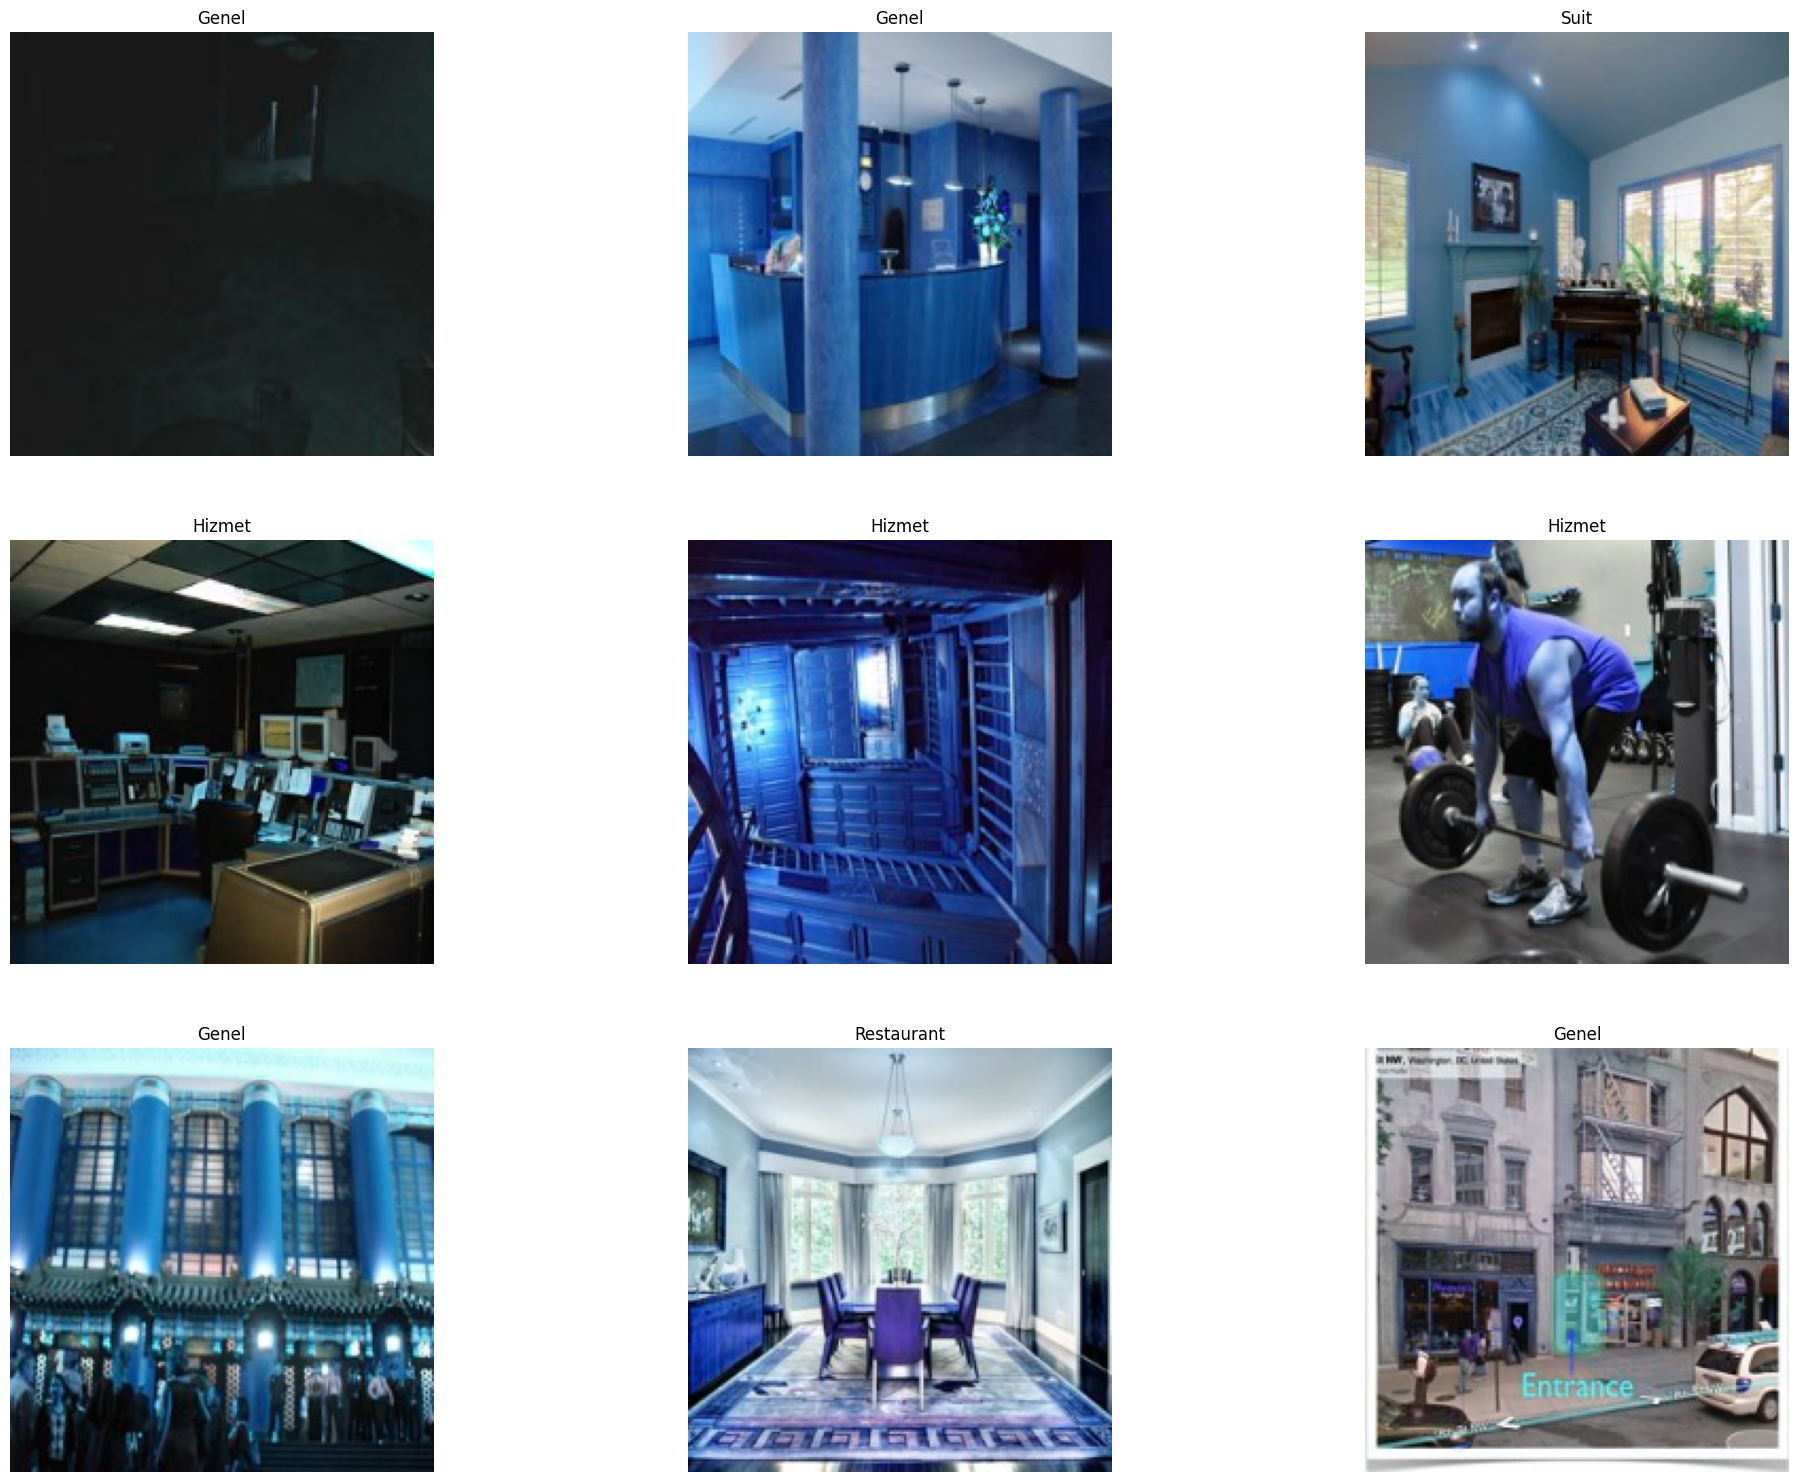

In [18]:
f,ax = plt.subplots(3,3) 
f.subplots_adjust(0,0,3,3)
for i in range(0,3,1):
    for j in range(0,3,1):
        rnd_number = randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == train_labels[rnd_number]][0])
        ax[i,j].axis('off')

# Define CNN Keras model and compile

In [19]:
def create_model():
    
    with tf.device('/gpu:0'):
    
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        x = layers.BatchNormalization()(input_layer)

        x = layers.Conv2D(filters=64, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_1')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
        x = layers.Dropout(0.1, name='dropout_1')(x)

        x = layers.Conv2D(filters=128, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_2')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
        x = layers.Dropout(0.1, name='dropout_2')(x)

        x = layers.Conv2D(filters=256, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_3')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
        x = layers.Dropout(0.1, name='dropout_3')(x)

        x = layers.Conv2D(filters=512, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_4')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
        x = layers.Dropout(0.1, name='dropout_4')(x)

        x = layers.Conv2D(filters=1024, kernel_size=3, 
                          activation='relu', padding='same', 
                          name='conv2d_5')(x)
        x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
        x = layers.Dropout(0.1, name='dropout_5')(x)
        

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)
       
        x = layers.Dense(128,activation='relu')(x)
        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 200, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                             

# Run model training

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import datetime

# TensorFlow Session başlatma (bu kısmı artık kullanmıyoruz)
# with tf.compat.v1.Session() as sess:

# Model oluşturma fonksiyonu
def create_model():
    input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
    x = layers.BatchNormalization()(input_layer)

    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_1')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_1')(x)
    x = layers.Dropout(0.1, name='dropout_1')(x)

    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_2')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_2')(x)
    x = layers.Dropout(0.1, name='dropout_2')(x)

    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_3')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_3')(x)
    x = layers.Dropout(0.1, name='dropout_3')(x)

    x = layers.Conv2D(filters=512, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_4')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_4')(x)
    x = layers.Dropout(0.1, name='dropout_4')(x)

    x = layers.Conv2D(filters=1024, kernel_size=3, 
                      activation='relu', padding='same', 
                      name='conv2d_5')(x)
    x = layers.MaxPool2D(pool_size=2, name='maxpool2d_5')(x)
    x = layers.Dropout(0.1, name='dropout_5')(x)

    x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
    x = layers.BatchNormalization()(x)
   
    x = layers.Dense(128, activation='relu')(x)
    
    output = layers.Dense(units=len(CLASSES), 
                          activation='softmax', 
                          name='output')(x)

    model = Model(input_layer, output)    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Modeli oluştur
model = create_model()
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200, 200, 3)]     0         
                                                                 
 batch_normalization_2 (Batc  (None, 200, 200, 3)      12        
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      1792      
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 100, 100, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                           

# Training process

In [ ]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
requared_time

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluate the trained model

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

# Prediction

In [ ]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

# Classification report & confusion matrix

In [ ]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

# Let's try pretrained model for example VGG19

In [ ]:
def create_model():
    with tf.device('/gpu:0'):
        pretrained_model = tf.keras.applications.VGG19(
            weights='imagenet',
            include_top=False ,
            input_shape=[*IMAGE_SIZE, 3]
        )
        pretrained_model.trainable = False

        
        
        input_layer = layers.Input(shape=(*IMAGE_SIZE, 3), name='input') 
        
        x = pretrained_model(input_layer)

        x = layers.GlobalAveragePooling2D(name='global_average_pooling2d')(x)
        x = layers.BatchNormalization()(x)       
        x = layers.Dense(128,activation='relu')(x)

        
        output = layers.Dense(units=len(CLASSES), 
                              activation='softmax', 
                              name='output')(x)


        model = Model (input_layer, output)    
        model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy', 
                      metrics=['accuracy'])

        return model

model = create_model()
model.summary()

In [ ]:
init_time = datetime.datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 1, verbose=1, factor=0.3, min_lr=0.000001)

trained = model.fit(
                    train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    batch_size = BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[learning_rate_reduction],
    )

requared_time = datetime.datetime.now() - init_time
print(f'\nRequired time:  {str(requared_time)}\n')

In [ ]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('\naccuracy:', test_acc, '  loss: ',test_loss)

# Prediction

In [ ]:
predict = np.argmax(model.predict(test_images), axis=1)
predict

# Classification report & confusion matrix

In [ ]:
print(classification_report(test_labels, predict), '\n')
cm = confusion_matrix(test_labels, predict)
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', cbar=False)
plt.show()

# Let's predict unlabeled images

In [ ]:
to_predict_images, to_predict_labels = get_images_and_labels_arrays(image_path_df_predict)
print(f'Shape of images set to prediction: {to_predict_images.shape}')

In [ ]:
predict = np.argmax(model.predict(to_predict_images), axis=1)
predict

# Let's check random images

In [ ]:
f,ax = plt.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(predict))
        ax[i,j].imshow(to_predict_images[rnd_number])
        ax[i,j].set_title([key for key, val in CLASSES.items() if val == predict[rnd_number]][0])
        ax[i,j].axis('off')

# Thank you for your attention and curiosity ;)